In [342]:
import pandas as pd 
import numpy as np 
import requests 
import seaborn as sns 
import matplotlib.pyplot as plt
from urllib.parse import urlencode
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import levene
from scipy.stats import bootstrap
import statsmodels.api as sm
from scipy import stats
import pandahouse as ph
import pingouin as pg

1. [A/B тестирование](#AB)   
1.1. [Расчет метрик](#metrics)  
1.2. [Выводы](#summary)
2. [SQL CLickHouse](#SQL)
3. [Реализации функции для доп. файла и визуализации метрик](#function)

<a name="AB"></a> 
## Задание 1. A/B–тестирование ##

**Условие: <br/>**
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Вопросы:**

1. На какие метрики вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?

**Входные данные:** <br/>

Считываем и загружаем данные в дата-фрейм из Яндекс диска с помощью API. <br/>
Поскольку у нас 4 дата-сета, то создадим функцию для удобства. 

In [30]:
def ya_disk(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    return response.json()['href']

In [34]:
checks = pd.read_csv(ya_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')

In [35]:
active_studs = pd.read_csv(ya_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';')

In [39]:
group_add = pd.read_csv(ya_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',')

In [43]:
groups = pd.read_csv(ya_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')

Начнем с предварительного анализа данных (EDA). 

Узнаем размер дата-фреймов, нет ли null значений и типы данных.

In [45]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [46]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [47]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [48]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Чекнем наличие дубликатов в данных. 

In [49]:
checks.duplicated().sum()

0

In [50]:
active_studs.duplicated().sum()

0

In [52]:
group_add.duplicated().sum()

0

In [53]:
groups.duplicated().sum()

0

Объединим группы в один df.

In [55]:
groups_full = pd.concat([group_add, groups])

In [61]:
groups_full.shape[0] == group_add.shape[0] + groups.shape[0]

True

In [62]:
groups_full.duplicated().sum()

0

In [70]:
groups_full.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [89]:
groups_full.shape

(74576, 2)

In [87]:
groups_full.id.nunique()

74576

In [90]:
active_studs.nunique()

student_id    8341
dtype: int64

Соединим groups_full и active_studs, чтобы посмотреть, сколько было активных пользователей в обеих группах в дни эксперимента. 

In [84]:
active_users = active_studs.merge(groups_full, how = 'left', left_on = 'student_id', right_on = 'id')

In [92]:
groups_full['active_user'] = groups_full['id'].isin(active_studs.student_id).astype(int)

In [104]:
groups_full['paying_user'] = groups_full['id'].isin(checks.student_id).astype(int)

In [106]:
groups_full.head()

,id,grp,active_user,paying_user
0,5694584,B,0,0
1,5694830,B,0,0
2,5695057,B,0,0
3,5698872,B,0,0
4,5699067,B,0,0


Теперь соединим с таблицей checks

In [105]:
groups_full.shape

(74576, 4)

In [107]:
full_df = groups_full.merge(checks, how='left', right_on='student_id', left_on = 'id').fillna(0)

In [108]:
full_df.head()

,id,grp,active_user,paying_user,student_id,rev
0,5694584,B,0,0,0.0,0.0
1,5694830,B,0,0,0.0,0.0
2,5695057,B,0,0,0.0,0.0
3,5698872,B,0,0,0.0,0.0
4,5699067,B,0,0,0.0,0.0


In [117]:
full_df = full_df[['id', 'grp', 'active_user', 'paying_user', 'rev']]

In [118]:
full_df.describe()

,id,active_user,paying_user,rev
count,7.457600e+04,74576.000000,74576.000000,74576.000000
mean,2.165617e+06,0.111846,0.007254,7.687808
std,2.786959e+06,0.315179,0.084864,110.907645
min,1.489000e+03,0.000000,0.000000,0.000000
25%,9.197188e+05,0.000000,0.000000,0.000000
50%,1.669752e+06,0.000000,0.000000,0.000000
75%,3.328121e+06,0.000000,0.000000,0.000000
max,2.010677e+08,1.000000,1.000000,4650.000000


In [115]:
pay_df = full_df.loc[full_df.rev > 0]

Замечаем странность (аномалию) в данных: есть юзеры, которые что-то купили, но они не были помечены как активные. 

In [116]:
pay_df.loc[(pay_df.active_user == 0) & (pay_df.paying_user == 1)]

,id,grp,active_user,paying_user,rev
131,3185,B,0,1,690.0
213,25973,B,0,1,690.0
217,26280,B,0,1,690.0
315,100645,B,0,1,630.0
346,102534,B,0,1,580.0
...,...,...,...,...,...
72544,5291900,B,0,1,199.0
72845,5331842,B,0,1,290.0
73724,5486319,B,0,1,199.0
74141,5562806,B,0,1,398.0


Таких кейсов 149, в условии не обозначено, что это за случаи (предположу, что это подписка и деньги списались автоматически, без активности пользователя), однако подтверждения у нас нет, получить его не можем, поэтому я бы предложила **удалить** такие данные (ввиду их малочисленности) для дальнейших проверок гипотез. 

In [127]:
pay_df = full_df.loc[(full_df.rev > 0) & (full_df.active_user == 1) & (full_df.paying_user == 1)]

In [194]:
pay_df.head()

,id,grp,active_user,paying_user,rev
55,5740903,B,1,1,1900.0000
93,1627,A,1,1,990.0000
312,100300,B,1,1,990.0000
412,108270,B,1,1,290.0000
3871,264473,B,1,1,1900.0001


In [128]:
pay_df.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


Нагляднее смотреть на такие данные на бокс-плоте. 

<Axes: xlabel='grp', ylabel='rev'>

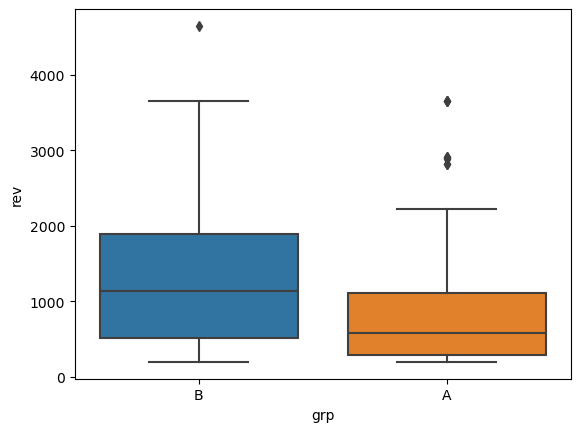

In [129]:
sns.boxplot(data=pay_df, y='rev', x='grp')

Медиана выше в группе В, межкваритильный размах больше в В и усы тоже.

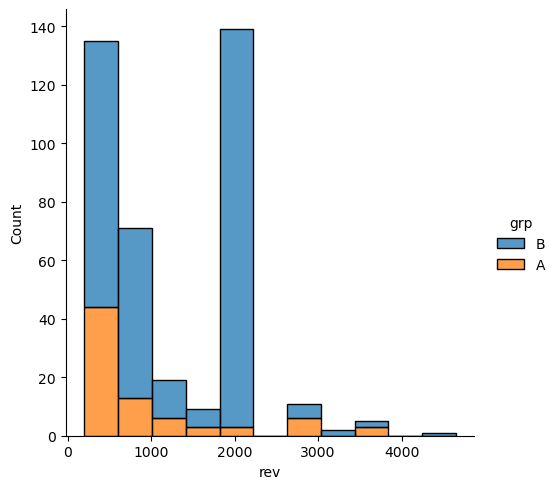

In [130]:
sns.displot(data=pay_df, x='rev', hue='grp', multiple="stack")

В группе А оплат было значительно меньше. 

<Axes: xlabel='grp', ylabel='rev'>

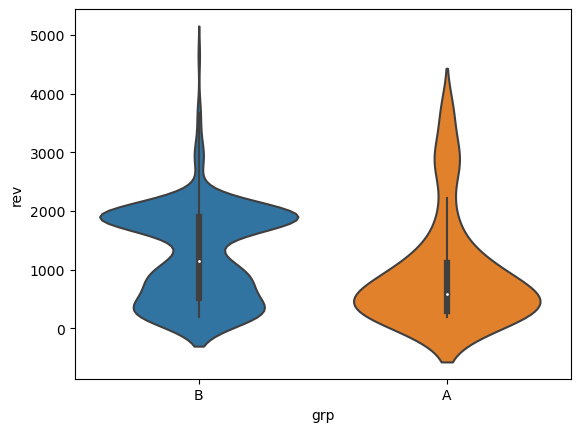

In [131]:
sns.violinplot(data=pay_df, y='rev', x='grp')

<a name="metrics"></a> 
## Метрики ##

Для бизнеса всегда будут наиболее важные показатели - метрики, связанные с деньгами, у нас как раз есть данные по доходу на каждого пользователя, поэтому отталкиваемся от этого. 

1. **ARPPU** - средний доход на платящего пользователя (и активного)
2. **ARPAU** - средний доход на активного пользователя (платящего и неплатящего) 
3. **CR** - конверсия в покупку - доля пользователей, ктр совершили покупку к общему числу посетителей сайта (активных)

### Начнем с **конверсии**, для начала рассчитаем этот показатель для обеих групп. ###

In [141]:
full_df.head()

,id,grp,active_user,paying_user,rev
0,5694584,B,0,0,0.0
1,5694830,B,0,0,0.0
2,5695057,B,0,0,0.0
3,5698872,B,0,0,0.0
4,5699067,B,0,0,0.0


In [148]:
full_count = full_df.loc[full_df.active_user == 1].groupby('grp', as_index=False).agg({'active_user':'count', 'paying_user':'sum', 'rev':'sum'})

In [150]:
full_count

,grp,active_user,paying_user,rev
0,A,1538,78,72820.0000
1,B,6803,314,394974.0035


In [155]:
full_count['CR'] = round(full_count.paying_user/full_count.active_user*100,2)

$H_0$: различий конверсий между группами нет <br/>
$H_1$: различия конверсий между группами статистически значимы

Конверсия - категориальная переменная (совершил целевое действие или нет), поэтому буду применять критерий Хи-квадрат. 

In [157]:
active_df = full_df.loc[full_df.active_user == 1]

In [158]:
active_df.head()

,id,grp,active_user,paying_user,rev
7,5700613,B,1,0,0.0
39,5723133,A,1,0,0.0
40,5723648,B,1,0,0.0
43,5728431,B,1,0,0.0
44,5729371,A,1,0,0.0


In [161]:
chi2_contingency(pd.crosstab(active_df.grp, active_df.paying_user))

Chi2ContingencyResult(statistic=0.48480826522557896, pvalue=0.48625240457231045, dof=1, expected_freq=array([[1465.71897854,   72.28102146],
       [6483.28102146,  319.71897854]]))

pvalue=0.48625240457231045 >> 0.05 <br/>

**ВЫВОД:** <br/>

**Стат. значимые различия** в конверсии мужду группами **отсутствуют**. 

### 2. Проверяем гипотезы о равенстве средних доходов с активных пользователей ARPAU ###

$H_0$: нет стат значимого различия в размере среднего дохода на активного пользователя <br/>
$H_1$: стат значимые различия в ARPAU между группами есть 

Сравнивая средние величины, необходимо проверить, можно ли использовать парам. критерий Стьюдента. 
Есть два условия его использования:
1. дисперсии по группам равны (гомоскедастичность);
2. нормальность распределения средних величин. 

In [165]:
control_arpau = active_df.query('grp == "A"')[['grp', 'rev']]

In [167]:
control_arpau.head()

,grp,rev
39,A,0.0
44,A,0.0
74,A,0.0
93,A,990.0
135,A,0.0


In [168]:
test_arpau = active_df.query('grp == "B"')[['grp', 'rev']]

In [169]:
test_arpau.head()

,grp,rev
7,B,0.0
40,B,0.0
43,B,0.0
49,B,0.0
54,B,0.0


In [275]:
ARPAU = round(full_df.query('active_user == 1').groupby('grp',as_index=False).agg({'rev':'mean'}),2).rename(columns={'grp':'group','rev':'ARPAU'})

In [276]:
ARPAU

,group,ARPAU
0,A,47.35
1,B,58.06


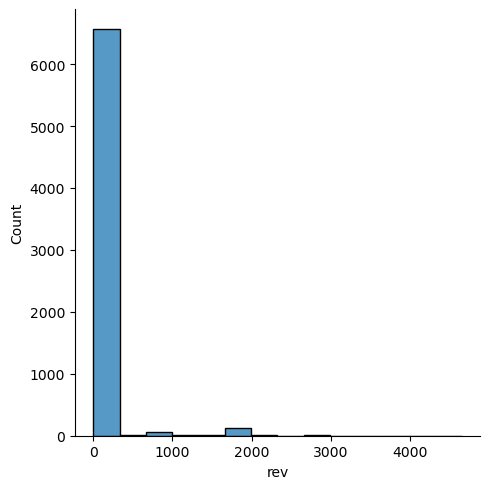

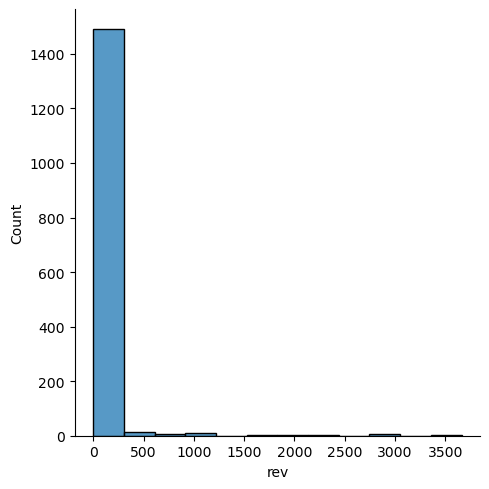

In [170]:
sns.displot(test_arpau.rev)
sns.displot(control_arpau.rev)

Проверка требования на гомогенность дисперсий с помощью критерия Левена.

In [173]:
stats.levene(control_arpau.rev, test_arpau.rev)

LeveneResult(statistic=1.5014608294336391, pvalue=0.22048133327049665)

pvalue=0.22048 >> 0.05, дисперсии гомогенны. 

In [224]:
means_control = []
n = 1

while n < 10000:
    n += 1
    sample = control_arpau['rev'].sample(frac=1, replace=True).mean()
    means_control.append(sample)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

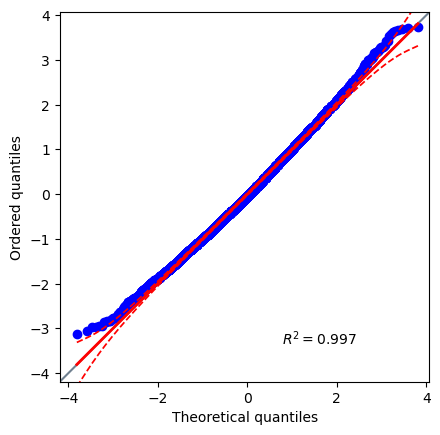

In [344]:
pg.qqplot(means_control)

In [225]:
shapiro(means_control)

ShapiroResult(statistic=0.9973580241203308, pvalue=2.63866467738183e-12)

In [226]:
means_test = []
n = 1

while n < 10000:
    n += 1
    sample = test_arpau['rev'].sample(frac=1, replace=True).mean()
    means_test.append(sample)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

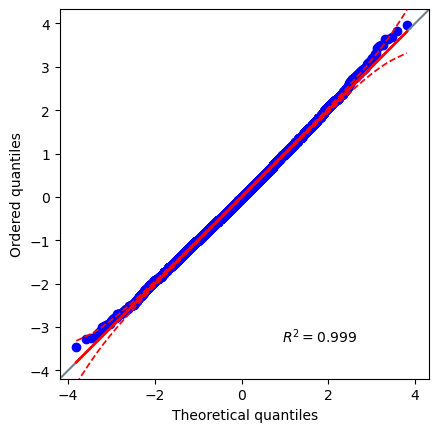

In [345]:
pg.qqplot(means_test)

In [227]:
shapiro(means_test)

ShapiroResult(statistic=0.9992501139640808, pvalue=0.00021055924298707396)

Распределение средних отлично от нормального, однако размер выборки позволяет нам использовать критерий Стьюдента 

In [192]:
stats.ttest_ind(control_arpau.rev, test_arpau.rev)

TtestResult(statistic=-1.2253411073793448, pvalue=0.22048133326988373, df=8339.0)

Pvalue > 0.05, стат значимых различий между ARPAU в группах не удалось выявить

### 3. Проверяем гипотезы о равенстве средних доходов с платящих пользователей ARPPU ###

$H_0$: нет стат значимого различия в размере среднего дохода на платящего пользователя <br/>
$H_1$: стат значимые различия есть в ARPPU между группами есть 

аналогично проверяем требования для использования критерия Стьюдента. 

In [195]:
pay_df_control = pay_df.loc[pay_df.grp == 'A']

In [196]:
pay_df_test = pay_df.loc[pay_df.grp == 'B']

In [280]:
ARPPU = round(full_df.query('active_user==1 and paying_user==1').groupby('grp',as_index=False).agg({'rev':'mean'}),2).rename(columns={'grp':'group','rev':'ARPPU'})

In [281]:
ARPPU

,group,ARPPU
0,A,933.59
1,B,1257.88


In [197]:
stats.levene(pay_df_control.rev, pay_df_test.rev)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Дисперсии равны

In [228]:
means_pay_control = []
n = 1

while n < 10000:
    n += 1
    sample = pay_df_control['rev'].sample(frac=1, replace=True).mean()
    means_pay_control.append(sample)

In [229]:
shapiro(means_pay_control)

ShapiroResult(statistic=0.9969038963317871, pvalue=1.2167396539093656e-13)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

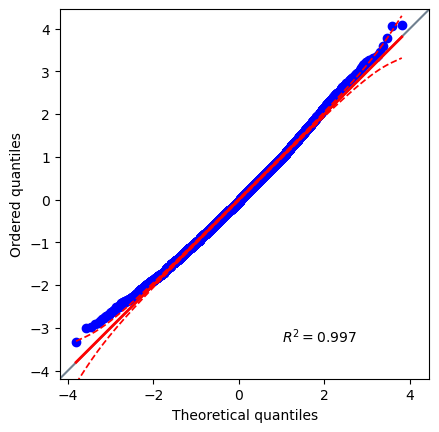

In [346]:
pg.qqplot(means_pay_control)

In [230]:
means_pay_test = []
n = 1

while n < 10000:
    n += 1
    sample = pay_df_test['rev'].sample(frac=1, replace=True).mean()
    means_pay_test.append(sample)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

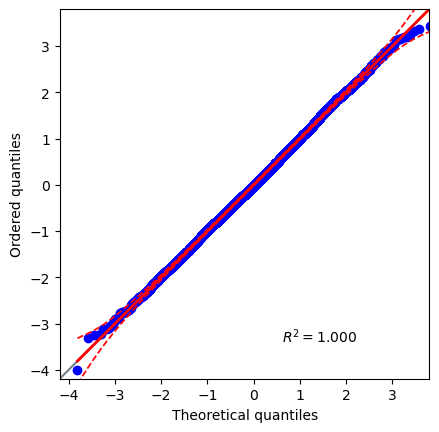

In [347]:
pg.qqplot(means_pay_test)

In [231]:
shapiro(means_pay_test)

ShapiroResult(statistic=0.9996488690376282, pvalue=0.06740745902061462)

диспрерсии равны, среднее в тестовой группе распределено нормально, а в контрольной нет, однако можем применить т-тест ввиду достаточности количества данных

In [239]:
stats.ttest_ind(pay_df_control.rev, pay_df_test.rev)

TtestResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867, df=390.0)

Статистический тест показал значимые различия для ARPPU.

<a name="summary"></a> 
## Вывод

Подведем итоги: 
1. Абсолютное значение **конверсии** в тестовой группе снизилось по сравнению с контрольной, стат. тест **НЕ показал стат. значимых различий**. 
2. Стат значимых различий между **ARPAU** в группах **не удалось выявить**
3. Статистический тест **показал значимые различия для ARPPU.**

**Вывод:** <br>
На мой взгляд, прежде, чем принимать какое-то решение необходимо узнать/уточнить природу выявленных аномалий в данных (возможно это ошибка и нужно перепроверить весь эксперимент, мб мое предположение с подпиской верно и эти данные нужно включить). <br>

Если все же брать текущие итоги, то здесь также стоит уточнить/согласовать с бизнесом основную метрику, на которую они ориентируются: ARPAU/ARPPU. От этого будет зависеть решение, выкатывать в прод (если ARPPU) или нет (если ARPAU). <br> 
На мой взгляд (если бы я была на месте бизнеса), с учетом аномалий и того факта, что стат значимые различия были только у ARPPU, я бы не стала выкатывать эту фичу на всех. 

<a name="SQL"></a> 
## Задание 2. SQL

**Условие** <br/>

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". <br/>

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин. <br/>

**Задача №1** <br/>

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Подключаемся к БД (СН). 

In [244]:
connection = dict(database= 'default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [245]:
query = """
select *
from default.peas
limit 5
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

KeyError: 'DateTime64(3)'

In [246]:
query = """
select 
        st_id, 
        toDateTime(timest) as timest, 
        correct, 
        subject
from default.peas
limit 5
"""
peas = ph.read_clickhouse(query, connection=connection)
peas

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [247]:
def print(query):
    peas = ph.read_clickhouse(query, connection=connection)
    return peas

In [249]:
print("""
select 
        max(toDateTime(timest)), 
        min(toDateTime(timest))
from default.peas
"""
)

,max(toDateTime(timest)),min(toDateTime(timest))
0,2021-10-31 17:29:52,2021-10-30 13:00:00


In [250]:
print("""
select 
        count(distinct st_id)
from default.peas
"""
)

,uniqExact(st_id)
0,308


In [253]:
print("""
select 
    count(distinct st_id) as good_studs
from default.peas
where st_id in (
                select st_id 
                from default.peas
                group by st_id
                having sum(correct) >=20
                )
"""
)

,good_studs
0,136


Если бы были еще задачи, в ктр необходимы усердные ученики, то с тз оптимальности нужно было бы вынести подзапрос в cte и переиспользовать его, но в рамках этой небольшой задачи можно ограничиться и подзапросом. 

### Ответ ###

Количество очень усердных студентов: 136

**Задача №2** <br/>

**Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

**Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**

1. ARPU 
2. ARPAU 
3. CR в покупку 
4. СR активного пользователя в покупку 
5. CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [266]:
print("""
select 
    *
from default.studs
limit 5
"""
)

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [257]:
print("""
select 
    st_id, 
    toDateTime(sale_time) as sale_time, 
    money, 
    subject
from default.final_project_check
limit 5
"""
)

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math


In [260]:
print("""
select 
    uniqExact(st_id)
from default.final_project_check
"""
)

,uniqExact(st_id)
0,47


In [261]:
print("""
select 
    uniqExact(st_id)
from default.studs
"""
)

,uniqExact(st_id)
0,600


In [268]:
print("""
select 
    test_grp,
    round(sum(money) / uniqExact(s.st_id), 2)as ARPU, 
    round(sumIf(money, active_user >10) / uniqExactIf(s.st_id, active_user >10),2) as ARPAU, 
    round(uniqExactIf(s.st_id, money > 0) / uniqExact(s.st_id)*100, 2) as CR_gen, 
    round(uniqExactIf(s.st_id, money > 0 and active_user >10) / uniqExactIf(s.st_id, active_user >10)*100,2) as CR_act, 
    round(uniqExactIf(s.st_id, money > 0 and math_active >=2 and subject = 'Math') / uniqExactIf(s.st_id, math_active >= 2)*100, 2) as CR_act_math
from 
    default.studs as s
left join 
    default.final_project_check as c
on s.st_id = c.st_id
left join 
    (select  
        st_id, 
        sumIf(correct,  subject = 'Math') as math_active, 
        sum(correct) as active_user
    from default.peas
    group by st_id) t
on s.st_id = t.st_id
group by test_grp

"""
)

,test_grp,ARPU,ARPAU,CR_gen,CR_act,CR_act_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


<a name="function"></a> 
### Задание 3. Python

**Задача №1.**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

сделаем допущение, что все остальные дата-сеты у нас уже загружены и помещены в дата-фреймы, поэтому сделаем загрузку только для groups_add, ктр расположен на Я.диске. 

In [324]:
def add_grp(groups, active_studs, checks):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    # можно будет подставить свой url в public_key
    public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    # допустим, что сепаратом опять выступает запятая, но лучше уточнить, 
    # чтобы было удобнее менять в случае, если какой-то иной символ
    groups_add = pd.read_csv(response.json()['href'], sep=',')
    # чекнем размерность (кол-во столбцов) дата-фрейма перед тем, как делать union с основной таблицей 
    if groups_add.shape[1] != 2:
        return None
    # На всякий случай переименуем заголовки столбцов, чтобы совпадало с основной таблицей 
    groups_add.rename(columns=({groups_add.columns[0]: 'id', groups_add.columns[1]: 'grp'}), inplace=True)  
    # теперь можно объединить с основным 
    full_groups = pd.concat([groups_add, groups])
    # чекаем, что ничего не потеряли 
    full_groups.shape[0] == groups_add.shape[0] + groups.shape[0]

    # начинаем работать со всеми таблицами, чтобы рассчитать метрики 
    full_groups['active_user'] = full_groups['id'].isin(active_studs.student_id).astype(int)
    full_groups['paying_user'] = full_groups['id'].isin(checks.id).astype(int)
    full_data = full_groups.merge(checks, how='left', on = 'id').fillna(0)
    
    # расчет мерик (конверсии , ARPAU, ARPPU), но сначала сделаем нашу основную таблицу со всеми метриками 
    # глобальной, чтобы она была "видна" вне этой функции
    global metric_table
    metric_table = full_data.query('active_user == 1').groupby('grp', as_index=False).agg({'active_user':'sum', 'paying_user':'sum','rev':'sum'})
    metric_table['CR'] = round(((metric_table.paying_user / metric_table.active_user)*100),2)
    metric_table['ARPAU'] = round((metric_table.rev / metric_table.active_user),2)
    metric_table['ARPPU'] = round((metric_table.rev / metric_table.paying_user),2)

    return metric_table  

In [325]:
add_grp(groups, active_studs, checks)

,grp,active_user,paying_user,rev,CR,ARPAU,ARPPU
0,A,1538,78,72820.0000,5.07,47.35,933.59
1,B,6803,314,394974.0035,4.62,58.06,1257.88


**Задача №2.**

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [340]:
def plots_met(metric):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    sns.barplot(x = "grp", y = "CR", data = metric_table, palette = "crest")
    plt.title("Конверсия")
    plt.subplot(1, 3, 2)
    sns.barplot(x = "grp", y = "ARPAU", data = metric_table, palette = "crest")
    plt.title("ARPAU")
    plt.subplot(1, 3, 3)
    sns.barplot(x = "grp", y = "ARPPU", data = metric_table, palette = "crest")
    plt.title("ARPPU")
    plt.show()

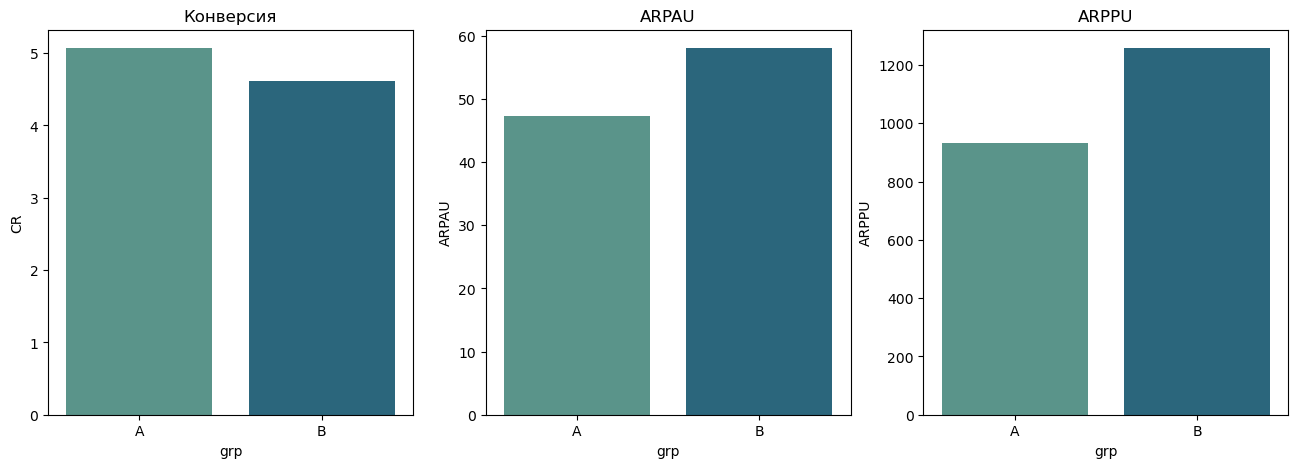

In [341]:
plots_met(metric_table)